In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, make_scorer, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from data_utils import load_metadata, sample_sounds_by_category, load_wave_data, load_all_sounds
from plot_utils import visualize_category_sounds,create_histogram_subplot
from feature_utils import combine_features_with_flags, test_feature_combinations_svm, compute_features_for_wave_list
from feature_utils import compute_combined_features_for_wave_list, save_features_to_npz, save_multiple_features_to_npz

In [2]:
# 1) Specify paths
csv_file_path = "datasets/ESC-50-master/meta/esc50.csv"
audio_files_path = "datasets/ESC-50-master/audio/"

# 1.1) check if the paths exist
assert os.path.exists(csv_file_path), "CSV file not found!"
assert os.path.exists(audio_files_path), "Audio directory not found!"


In [3]:
# 2) Load metadata
df = load_metadata(csv_file_path)

print(df)
print("Missing values:\n", df.isnull().sum()) # Check for missing values
print(df.describe()) # Show summary statistics

               filename  fold  target        category  esc10  src_file take
0      1-100032-A-0.wav     1       0             dog   True    100032    A
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
...                 ...   ...     ...             ...    ...       ...  ...
1995   5-263831-B-6.wav     5       6             hen  False    263831    B
1996  5-263902-A-36.wav     5      36  vacuum_cleaner  False    263902    A
1997   5-51149-A-25.wav     5      25       footsteps  False     51149    A
1998    5-61635-A-8.wav     5       8           sheep  False     61635    A
1999     5-9032-A-0.wav     5       0             dog   True      9032    A

[2000 rows x 7 columns]
Missing values:
 filename    0
fold        0
target      0
cate

Class counts for selected categories:
 category
dog               40
vacuum_cleaner    40
thunderstorm      40
pouring_water     40
clock_alarm       40
helicopter        40
snoring           40
sneezing          40
rooster           40
siren             40
Name: count, dtype: int64
✅ All classes have 40 rows.


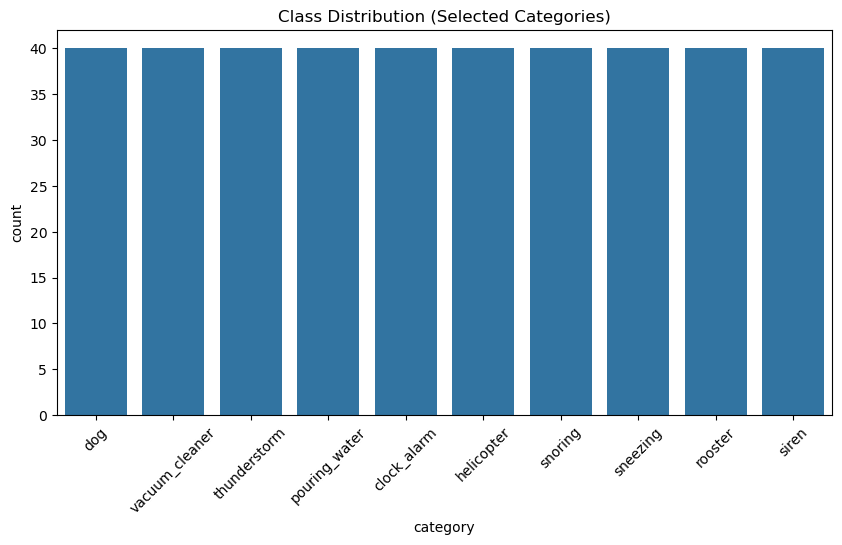

In [4]:
# 3) Define categories
categories = {
        'Animals': ['dog', 'rooster'],
        'Natural soundscapes & water sounds': ['thunderstorm', 'pouring_water'],
        'Human sounds': ['snoring', 'sneezing'],
        'Interior/domestic sounds': ['clock_alarm', 'vacuum_cleaner'],
        'Exterior/urban noises': ['siren', 'helicopter']
    }
# Filter the dataframe to only include selected categories
selected_classes = sum(categories.values(), [])  # Flatten the dictionary into a list of class names
df_filtered = df[df['category'].isin(selected_classes)]  # Keep only selected categories


class_counts = df_filtered['category'].value_counts()
print("Class counts for selected categories:\n", class_counts)
if all(class_counts == 40):
    print("✅ All classes have 40 rows.")
else:
    print("❌ Some classes do not have 40 rows.")
    print("Classes with insufficient rows:\n", class_counts[class_counts != 40])

# Plot class distribution of selected categories
plt.figure(figsize=(10, 5))
sns.countplot(x=df_filtered['category'])
plt.xticks(rotation=45)
plt.title("Class Distribution (Selected Categories)")
plt.show()



In [5]:
# Create a mapping dictionary from category to its target number
category_to_target = dict(zip(df_filtered['category'], df_filtered['target']))

# Print the dictionary
print("Category to Target Mapping:\n", category_to_target)

Category to Target Mapping:
 {'dog': 0, 'vacuum_cleaner': 36, 'thunderstorm': 19, 'pouring_water': 17, 'clock_alarm': 37, 'helicopter': 40, 'snoring': 28, 'sneezing': 21, 'rooster': 1, 'siren': 42}


In [6]:
# 4) Sample sounds
sampled_sounds = sample_sounds_by_category(df, categories)

# Track missing and represented classes
missing_classes = {}
represented_classes = {}

for category, expected_classes in categories.items():
    # Extract actual classes from sampled sounds
    sampled_classes = set(df[df['filename'].isin(sampled_sounds[category])]['category'])
    
    # Check which classes are missing
    missing = set(expected_classes) - sampled_classes
    represented_classes[category] = sampled_classes

    if missing:
        missing_classes[category] = missing

    print(f"Category: {category}, Sampled Classes: {sampled_classes}")

# Summary
print("\n✅ Represented Classes:")
for category, classes in represented_classes.items():
    print(f"- {category}: {classes}")

if missing_classes:
    print("\n❌ Missing Classes:")
    for category, classes in missing_classes.items():
        print(f"- {category}: {classes}")
else:
    print("\n🎉 All expected classes are present!")


Category: Animals, Sampled Classes: {'dog', 'rooster'}
Category: Natural soundscapes & water sounds, Sampled Classes: {'pouring_water', 'thunderstorm'}
Category: Human sounds, Sampled Classes: {'sneezing', 'snoring'}
Category: Interior/domestic sounds, Sampled Classes: {'vacuum_cleaner', 'clock_alarm'}
Category: Exterior/urban noises, Sampled Classes: {'helicopter', 'siren'}

✅ Represented Classes:
- Animals: {'dog', 'rooster'}
- Natural soundscapes & water sounds: {'pouring_water', 'thunderstorm'}
- Human sounds: {'sneezing', 'snoring'}
- Interior/domestic sounds: {'vacuum_cleaner', 'clock_alarm'}
- Exterior/urban noises: {'helicopter', 'siren'}

🎉 All expected classes are present!


In [7]:
# 5) Load wave data
wave_list_data_sampled = load_wave_data(sampled_sounds, audio_files_path) #load_sample
wave_list_data = load_all_sounds(df, categories, audio_files_path) #load all sounds

print("Total samples loaded:", len(wave_list_data))
print("Example sample rate:", wave_list_data[0][2])
print("Example waveform shape:", wave_list_data[0][3].shape)

Total samples loaded: 400
Example sample rate: 44100
Example waveform shape: (220500,)


In [8]:
# 6) Visualize
# visualize_category_sounds(wave_list_data_sampled)

In [9]:
# 7) Extract all features
# keys_list, combined_features = compute_combined_features_for_wave_list(wave_list_data)

In [10]:
# # 8) Save all features
# save_features_to_npz(keys_list, combined_features, out_file="features/extracted_features_combined.npz")

# # Check file integrity after saving
# loaded_data = np.load("features/extracted_features_combined.npz")
# print("Loaded feature shape:", loaded_data['features'].shape)
# print("Keys shape:", loaded_data['keys'].shape)

In [11]:
# 7) Extract selected features
keys_list, mfcc_list, hist_list, spectral_list, zcr_list, envelope_list, hnr_list = compute_features_for_wave_list(wave_list_data)

# 8) Save selected features
save_multiple_features_to_npz(
    keys_list, 
    mfcc_list, 
    hist_list, 
    spectral_list, 
    zcr_list, 
    envelope_list, 
    hnr_list, 
    out_file="features/extracted_features_multiple_test.npz"
)

Multiple features saved to features/extracted_features_multiple_test.npz


In [12]:
# Load saved features
loaded_data = np.load("features/extracted_features_multiple_test.npz")

# Define which features to include (set True to include, False to exclude)
feature_selection = {
    'mfcc': True,
    'hist': True,
    'spectral': True,
    'zcr': True,
    'envelope': True,
    'hnr': True
}

# Display the shapes of each feature type
print("Feature shapes and selection status:")
for feature, include in feature_selection.items():
    shape = loaded_data[feature].shape
    status = "✅" if include else "❌"
    print(f"{feature.capitalize()} shape: {shape} - Status: {status}")

# Extract features and labels
keys_list = loaded_data['keys']
mfcc_features = loaded_data['mfcc']
hist_features = loaded_data['hist']
spectral_features = loaded_data['spectral']
zcr_features = loaded_data['zcr']
envelope_features = loaded_data['envelope']
hnr_features = loaded_data['hnr']

# Display first feature vectors for verification
# print("First MFCC feature vector:", loaded_data['mfcc'][0])
# print("First histogram feature vector:", loaded_data['hist'][0])
# print("First spectral feature vector:", loaded_data['spectral'][0])
# print("First ZCR feature vector:", loaded_data['zcr'][0])
# print("First Amplitude Envelope feature vector:", loaded_data['envelope'][0])
# print("First HNR feature vector:", loaded_data['hnr'][0])

# Combine features based on flags
combined_features = combine_features_with_flags(loaded_data, feature_selection)
print("\nCombined features shape:", combined_features.shape)

Feature shapes and selection status:
Mfcc shape: (400, 26) - Status: ✅
Hist shape: (400, 80) - Status: ✅
Spectral shape: (400, 20) - Status: ✅
Zcr shape: (400, 2) - Status: ✅
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ✅

Combined features shape: (400, 134)


In [13]:
# Load saved features
loaded_data = np.load("features/extracted_features_multiple_test.npz")

# Define which features to include (set True to include, False to exclude)
feature_selection = {
    'mfcc': True,
    'hist': True,
    'spectral': True,
    'zcr': True,
    'envelope': True,
    'hnr': True
}

# Display the shapes of each feature type
print("Feature shapes and selection status:")
for feature, include in feature_selection.items():
    shape = loaded_data[feature].shape
    status = "✅" if include else "❌"
    print(f"{feature.capitalize()} shape: {shape} - Status: {status}")

# Extract features and labels
keys_list = loaded_data['keys']
mfcc_features = loaded_data['mfcc']
hist_features = loaded_data['hist']
spectral_features = loaded_data['spectral']
zcr_features = loaded_data['zcr']
envelope_features = loaded_data['envelope']
hnr_features = loaded_data['hnr']

# Display first feature vectors for verification
# print("First MFCC feature vector:", loaded_data['mfcc'][0])
# print("First histogram feature vector:", loaded_data['hist'][0])
# print("First spectral feature vector:", loaded_data['spectral'][0])
# print("First ZCR feature vector:", loaded_data['zcr'][0])
# print("First Amplitude Envelope feature vector:", loaded_data['envelope'][0])
# print("First HNR feature vector:", loaded_data['hnr'][0])

# Combine features based on flags
combined_features = combine_features_with_flags(loaded_data, feature_selection)
print("\nCombined features shape:", combined_features.shape)

Feature shapes and selection status:
Mfcc shape: (400, 26) - Status: ✅
Hist shape: (400, 80) - Status: ✅
Spectral shape: (400, 20) - Status: ✅
Zcr shape: (400, 2) - Status: ✅
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ✅

Combined features shape: (400, 134)


/var/folders/mj/tvn3vfr55f56l2_qx4xbdnp00000gn/T/ipykernel_51057/2109124173.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features["label"] = df_features["label"]  # Re-add labels


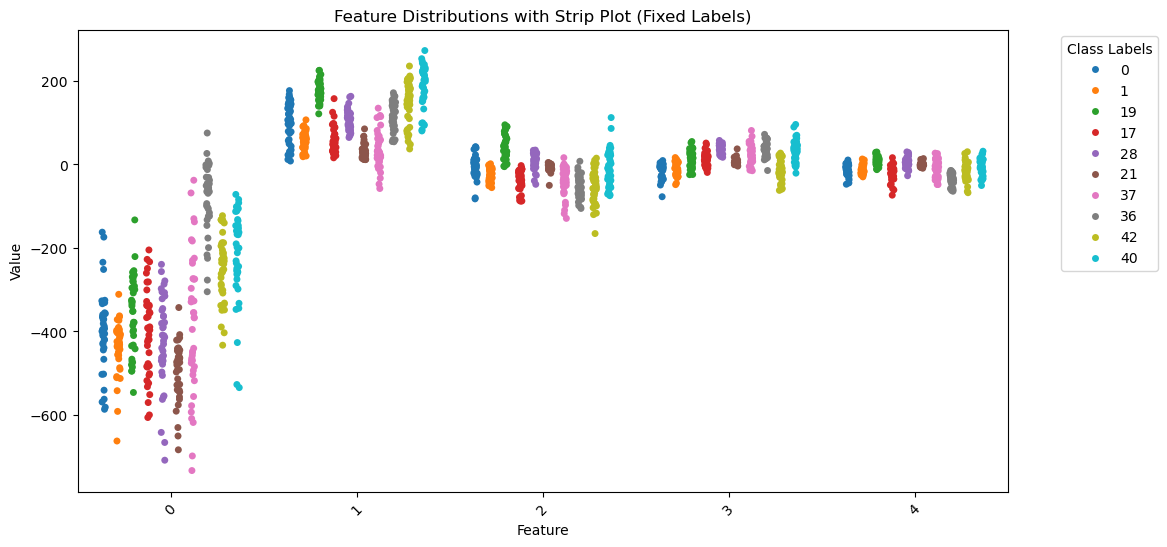

In [14]:
### Compare feature distributions for different classes

# Convert combined_features to DataFrame
df_features = pd.DataFrame(combined_features)
df_features["label"] = keys_list  # Add class labels

# Ensure labels are categorical, not just numbers
df_features["label"] = df_features["label"].astype(str)  # Convert to string labels

# Select first 5 features for visualization (modify if needed)
selected_features = df_features.iloc[:, :5]  
selected_features["label"] = df_features["label"]  # Re-add labels

# Convert to long format for plotting
df_melted = selected_features.melt(id_vars="label", var_name="Feature", value_name="Value")

# --- Strip Plot Fix ---
plt.figure(figsize=(12, 6))
sns.stripplot(x="Feature", y="Value", hue="label", data=df_melted, dodge=True, jitter=True)
plt.title("Feature Distributions with Strip Plot (Fixed Labels)")
plt.xticks(rotation=45)
plt.legend(title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')  # Fix legend
plt.show()



In [15]:
# Train-Test Splitting
X = combined_features
y = np.array(keys_list)

# Train-test split
X_train_not_scaled, X_test_not_scaled, y_train, y_test = train_test_split(
    combined_features, np.array(keys_list), test_size=0.2, random_state=42, stratify=keys_list
)


In [16]:
# Normalize the data using Z-score normalization (StandardScaler)
scaler = StandardScaler()


# feature normalization:
# feature = feature - mean(feature acrocss all examples) / std(feature across all examples)
## VERY IMPORTANT: the above mean and std must be calcualted from TRAIN data only, not from EVAL or TEST data

# Fit only on the training data and transform both train and test sets
X_train = scaler.fit_transform(X_train_not_scaled)  # Fit on train data only
X_test = scaler.transform(X_test_not_scaled)        # Use train's mean and std to scale test data

In [17]:
# Print sizes of train and test sets
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Debugging - Check which classes exist before and after splitting
unique_classes = set(keys_list)
print("Unique classes in dataset before splitting:", unique_classes)

# Count occurrences of each class in train and test sets
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

# Print class counts for debugging purposes
print("\nTraining Class Counts:\n", train_counts)
print("\nTest Class Counts:\n", test_counts)

Training set size: (320, 134)
Test set size: (80, 134)
Unique classes in dataset before splitting: {0, 1, 36, 37, 40, 42, 17, 19, 21, 28}

Training Class Counts:
 0     32
1     32
17    32
19    32
21    32
28    32
36    32
37    32
40    32
42    32
Name: count, dtype: int64

Test Class Counts:
 0     8
1     8
17    8
19    8
21    8
28    8
36    8
37    8
40    8
42    8
Name: count, dtype: int64


In [18]:
# Convert lists to Pandas Series for counting
train_counts = pd.Series(y_train).value_counts()
test_counts = pd.Series(y_test).value_counts()

# Merge train and test counts into a single DataFrame
df_counts = pd.DataFrame({'Train': train_counts, 'Test': test_counts}).fillna(0).astype(int)

# Plot bar chart for class distributions
# df_counts.plot(kind="bar", figsize=(10, 5), color=["blue", "red"], alpha=0.7)
# plt.xlabel("Class Labels")
# plt.ylabel("Count")
# plt.title("Train vs Test Class Distribution (Selected Classes Only)")
# plt.xticks(rotation=45)
# plt.legend(title="Dataset")
# plt.show()


# Display the counts table with a better format
print("\nClass Distribution Table:")
print(df_counts.to_string())

# Display summary
print("\nSummary:")
print(f"Total samples in Train set: {df_counts['Train'].sum()}")
print(f"Total samples in Test set: {df_counts['Test'].sum()}")



Class Distribution Table:
    Train  Test
0      32     8
1      32     8
17     32     8
19     32     8
21     32     8
28     32     8
36     32     8
37     32     8
40     32     8
42     32     8

Summary:
Total samples in Train set: 320
Total samples in Test set: 80


In [19]:
# # Define Stratified K-Fold
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Define hyperparameter grid
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],  # Reasonable range of C values
#     'gamma': [0.01, 0.1, 1, 'scale', 10, 100],  # Includes 'scale'
#     'kernel': ['rbf']  # Using only RBF kernel
# }

# # Perform GridSearch with Stratified K-Fold
# grid_search = GridSearchCV(SVC(), param_grid, cv=kfold, verbose=2, n_jobs=-1)

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Print best hyperparameters
# print("Best parameters:", grid_search.best_params_)

In [20]:
# Custom AUC scorer for multi-class (One-vs-Rest)
auc_scorer = make_scorer(roc_auc_score, multi_class='ovr', response_method='predict_proba')

# Initialize Stratified K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale', 10, 100],
    'kernel': ['rbf']
}

# Perform GridSearchCV with the custom AUC scorer
grid_search = GridSearchCV(
    SVC(probability=True),
    param_grid=param_grid,
    scoring=auc_scorer,
    cv=kfold,
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and mean AUC during cross-validation
print("\nBest hyperparameters:", grid_search.best_params_)
print("Best mean AUC during cross-validation:", grid_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best hyperparameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best mean AUC during cross-validation: 0.9839110707803993



AUC on the test set: 0.9894097222222221

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       1.00      0.88      0.93         8
          17       0.88      0.88      0.88         8
          19       0.64      0.88      0.74         8
          21       0.80      1.00      0.89         8
          28       1.00      0.88      0.93         8
          36       0.89      1.00      0.94         8
          37       0.73      1.00      0.84         8
          40       0.75      0.38      0.50         8
          42       1.00      1.00      1.00         8

    accuracy                           0.85        80
   macro avg       0.87      0.85      0.84        80
weighted avg       0.87      0.85      0.84        80


Accuracy on the test set: 0.85


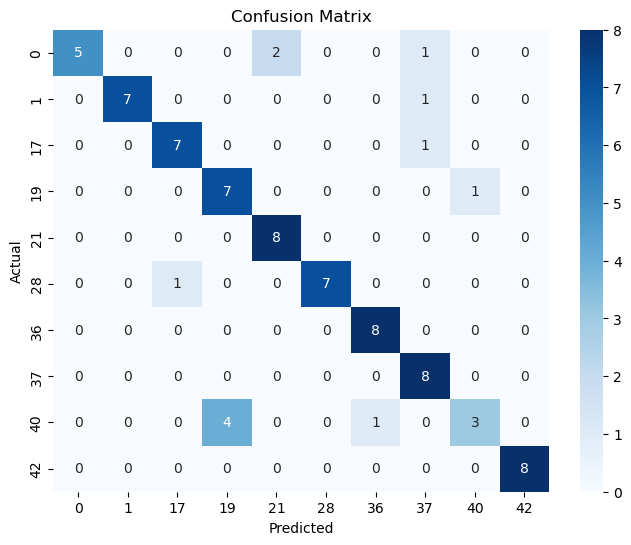

In [21]:
# Initialize the SVM classifier with the best hyperparameters
svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)

# Train the SVM classifier on the training set
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)
y_prob = svm.predict_proba(X_test)

# Evaluate AUC on the test set
test_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("\nAUC on the test set:", test_auc)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy on the test set:", accuracy)

# # Calculate TPR and FPR for each class
# tpr_list = []
# fpr_list = []

# print("\nTPR (Recall) and FPR for Each Class:")
# for i in range(len(cm)):  # Iterate over each class
#     tp = cm[i, i]  # True positives for class i
#     fn = sum(cm[i, :]) - tp  # False negatives for class i
#     fp = sum(cm[:, i]) - tp  # False positives for class i
#     tn = cm.sum() - (tp + fn + fp)  # True negatives for class i

#     tpr = tp / (tp + fn) if (tp + fn) != 0 else 0  # Avoid division by zero
#     fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # Avoid division by zero

#     tpr_list.append(tpr)
#     fpr_list.append(fpr)

#     print(f"Class {i}: TPR (Recall) = {tpr:.2f}, FPR = {fpr:.2f}")

# Visualize the confusion matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

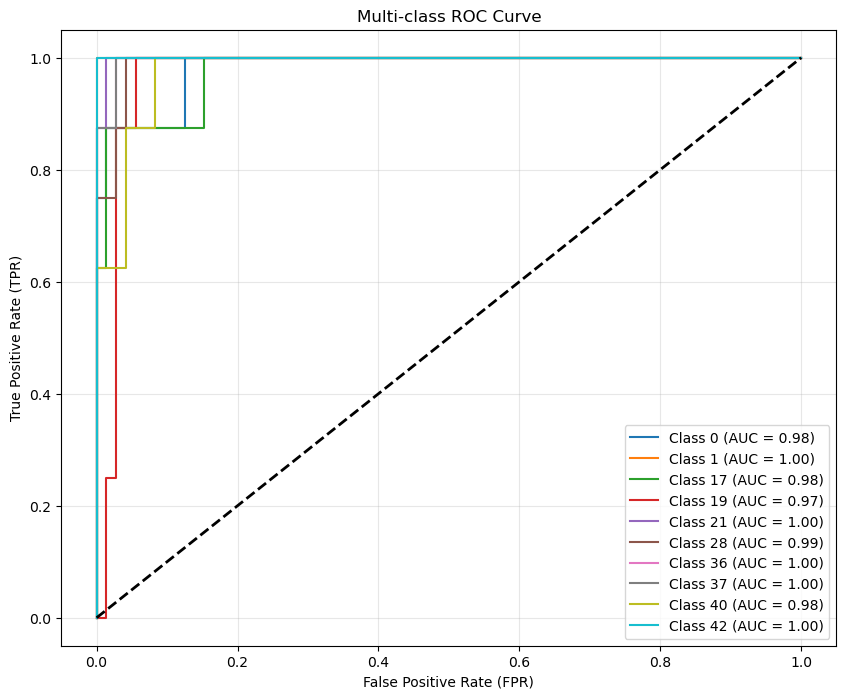

In [22]:
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC (One-vs-Rest)
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Initialize a plot
plt.figure(figsize=(10, 8))

# Loop through each class and compute ROC curve and AUC
for i in range(len(np.unique(y_test))):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {np.unique(y_test)[i]} (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packa

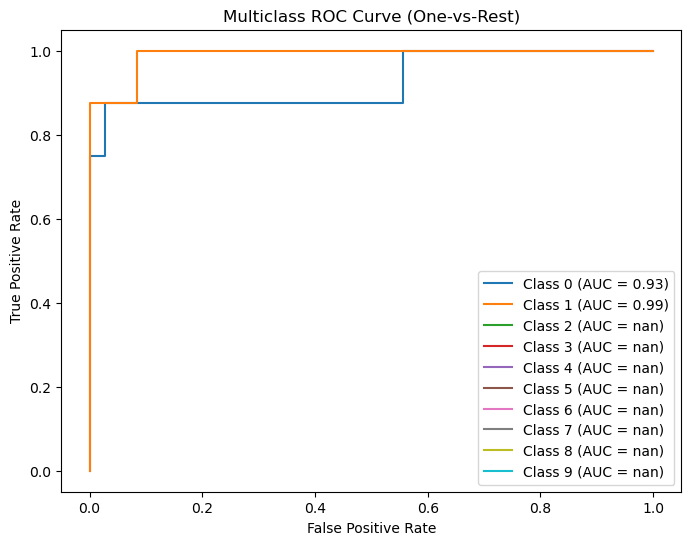

In [23]:
# Get decision function scores
y_scores = svm.decision_function(X_test)

num_classes = y_scores.shape[1]  # Number of classes

plt.figure(figsize=(8, 6))

for class_idx in range(num_classes):
    # Convert multi-class labels into binary (One vs. Rest)
    y_test_binary = (y_test == class_idx).astype(int)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test_binary, y_scores[:, class_idx])
    roc_auc = auc(fpr, tpr)

    # Plot each class's ROC curve
    plt.plot(fpr, tpr, label=f"Class {class_idx} (AUC = {roc_auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.show()


In [24]:
# Reduce features to  dimensions using PCA
pca = PCA(n_components=0.8)  
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)  

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Reduced feature shape:", X_train_pca.shape)

Explained variance ratio: [0.19509209 0.08515698 0.07228955 0.05691698 0.04521919 0.03602601
 0.03333351 0.03017803 0.02560287 0.02305684 0.02101277 0.01755981
 0.01651567 0.01617374 0.01493781 0.01432483 0.01374819 0.01357472
 0.01244197 0.01181433 0.0112548  0.01099488 0.0103654  0.00963513
 0.0094624 ]
Reduced feature shape: (320, 25)



AUC on the test set: 0.986111111111111

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.89      1.00      0.94         8
          17       0.83      0.62      0.71         8
          19       0.64      0.88      0.74         8
          21       0.73      1.00      0.84         8
          28       0.67      0.75      0.71         8
          36       0.88      0.88      0.88         8
          37       1.00      1.00      1.00         8
          40       0.80      0.50      0.62         8
          42       1.00      1.00      1.00         8

    accuracy                           0.82        80
   macro avg       0.84      0.82      0.82        80
weighted avg       0.84      0.82      0.82        80



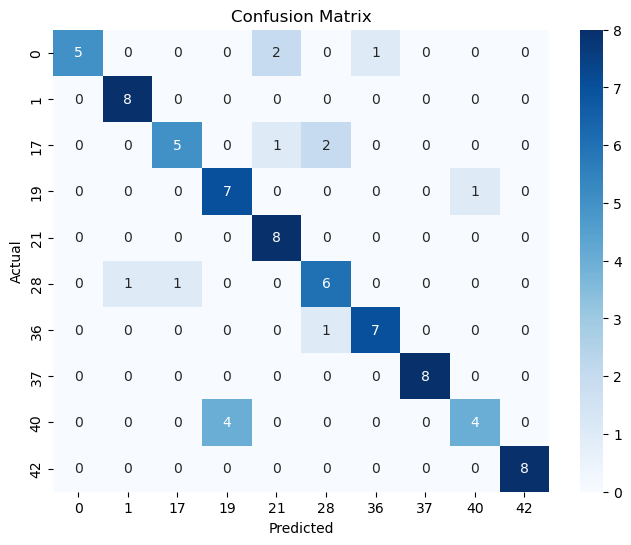

In [25]:
svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
svm.fit(X_train_pca, y_train)

# Step 3: Evaluate the classifier
y_pred = svm.predict(X_test_pca)
y_prob = svm.predict_proba(X_test_pca)

# Step 4: Calculate metrics
test_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("\nAUC on the test set:", test_auc)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Define feature combinations
feature_combinations = {
    'mfcc': mfcc_features,
    'spectral': spectral_features,
    'hist': hist_features,
    'zcr': zcr_features,
    'envelope': envelope_features,
    'hnr': hnr_features
}

In [27]:
# Run the function and print the top combinations
results = test_feature_combinations_svm(
    feature_combinations, 
    y, 
    n_pca_components=0.8, 
    normalize=True, 
    apply_pca=False
)

print("\nTop Feature Combinations by AUC and Accuracy:")
for result in results[:5]:  # Show top 5
    print(f"Combination: {result['combination']}, AUC: {result['average_auc']:.4f}, Accuracy: {result['average_accuracy']:.4f}")

Applied normalization for combination: ('mfcc',)
Tested combination: ('mfcc',), AUC = 0.9582, Accuracy = 0.7188
Applied normalization for combination: ('spectral',)
Tested combination: ('spectral',), AUC = 0.9753, Accuracy = 0.7719
Applied normalization for combination: ('hist',)
Tested combination: ('hist',), AUC = 0.9020, Accuracy = 0.5875
Applied normalization for combination: ('zcr',)
Tested combination: ('zcr',), AUC = 0.8669, Accuracy = 0.4437
Applied normalization for combination: ('envelope',)
Tested combination: ('envelope',), AUC = 0.8891, Accuracy = 0.4813
Applied normalization for combination: ('hnr',)
Tested combination: ('hnr',), AUC = 0.7479, Accuracy = 0.1875
Applied normalization for combination: ('mfcc', 'spectral')
Tested combination: ('mfcc', 'spectral'), AUC = 0.9807, Accuracy = 0.8438
Applied normalization for combination: ('mfcc', 'hist')
Tested combination: ('mfcc', 'hist'), AUC = 0.9664, Accuracy = 0.7656
Applied normalization for combination: ('mfcc', 'zcr')
T

In [199]:
# Load saved features
loaded_data = np.load("features/extracted_features_multiple_test.npz")

# Define which features to include (set True to include, False to exclude)
feature_selection = {
    'mfcc': True,
    'hist': False,
    'spectral': True,
    'zcr': True,
    'envelope': True,
    'hnr': True
}

# Display the shapes of each feature type
print("Feature shapes and selection status:")
for feature, include in feature_selection.items():
    shape = loaded_data[feature].shape
    status = "✅" if include else "❌"
    print(f"{feature.capitalize()} shape: {shape} - Status: {status}")

# Extract features and labels
keys_list = loaded_data['keys']
mfcc_features = loaded_data['mfcc']
hist_features = loaded_data['hist']
spectral_features = loaded_data['spectral']
zcr_features = loaded_data['zcr']
envelope_features = loaded_data['envelope']
hnr_features = loaded_data['hnr']

# Combine features based on flags
combined_features = combine_features_with_flags(loaded_data, feature_selection)
print("\nCombined features shape:", combined_features.shape)

# Train-Test Splitting
X = combined_features
y = np.array(keys_list)

# Train-test split
X_train_not_scaled, X_test_not_scaled, y_train, y_test = train_test_split(
    combined_features, np.array(keys_list), test_size=0.2, random_state=42, stratify=keys_list
)

# Normalize the data using Z-score normalization (StandardScaler)
scaler = StandardScaler()

# Fit only on the training data and transform both train and test sets
X_train = scaler.fit_transform(X_train_not_scaled)  # Fit on train data only
X_test = scaler.transform(X_test_not_scaled)        # Use train's mean and std to scale test data



Feature shapes and selection status:
Mfcc shape: (400, 26) - Status: ✅
Hist shape: (400, 80) - Status: ❌
Spectral shape: (400, 20) - Status: ✅
Zcr shape: (400, 2) - Status: ✅
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ✅

Combined features shape: (400, 54)


In [201]:
# # Reduce features to  dimensions using PCA
# pca = PCA(n_components=0.95)  
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)  

# print("Explained variance ratio:", pca.explained_variance_ratio_)
# print("Reduced feature shape:", X_train.shape)

In [203]:
# Custom AUC scorer for multi-class (One-vs-Rest)
auc_scorer = make_scorer(roc_auc_score, multi_class='ovr', response_method='predict_proba')

# Initialize Stratified K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale', 10, 100],
    'kernel': ['rbf']
}

# Perform GridSearchCV with the custom AUC scorer
grid_search = GridSearchCV(
    SVC(probability=True),
    param_grid=param_grid,
    scoring=auc_scorer,
    cv=kfold,
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and mean AUC during cross-validation
print("\nBest hyperparameters:", grid_search.best_params_)
print("Best mean AUC during cross-validation:", grid_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best hyperparameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Best mean AUC during cross-validation: 0.985989110707804



AUC on the test set: 0.9831597222222224

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       1.00      0.75      0.86         8
          17       0.86      0.75      0.80         8
          19       0.70      0.88      0.78         8
          21       0.67      1.00      0.80         8
          28       0.75      0.75      0.75         8
          36       1.00      1.00      1.00         8
          37       0.80      1.00      0.89         8
          40       1.00      0.62      0.77         8
          42       1.00      1.00      1.00         8

    accuracy                           0.85        80
   macro avg       0.88      0.85      0.85        80
weighted avg       0.88      0.85      0.85        80


Accuracy on the test set: 0.85


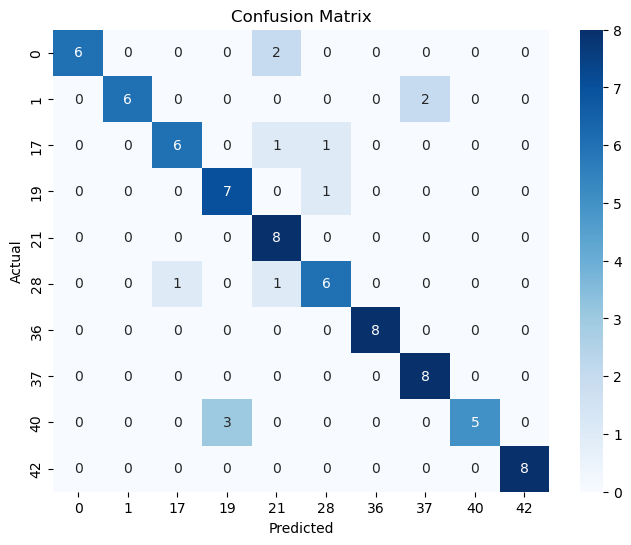

In [213]:
# Initialize the SVM classifier with the best hyperparameters
svm = SVC(kernel='rbf', C=1, gamma=0.01, probability=True, random_state=42)

# Train the SVM classifier on the training set
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)
y_prob = svm.predict_proba(X_test)

# Evaluate AUC on the test set
test_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("\nAUC on the test set:", test_auc)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy on the test set:", accuracy)


# Visualize the confusion matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [215]:
train_accuracy = svm.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

Training Accuracy: 0.94375
